<a href="https://colab.research.google.com/github/linhoangce/ml_with_pytorch_and_scikitlearn/blob/main/chapter11_practice_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying handwritten digits

In [ ]:
!pip install torchvision -q

In [26]:
# Download and prepare MNIST dataset
import torchvision

mnist_train = torchvision.datasets.MNIST(root='./',
                    train=True,
                    download=True)
mnist_test = torchvision.datasets.MNIST(root='./',
                   train=False,
                   download=True)

mnist_train.data.shape, mnist_test.data.shape


(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [27]:
# extract features and labels, and convert to numpy arr
X = mnist_train.data.numpy()
y = mnist_train.targets.numpy()
X_test = mnist_test.data.numpy()
y_test = mnist_test.targets.numpy()

X.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [28]:
# reshape features
X = X.reshape(-1, 28*28) # equals to X.reshape(X.shape[0], 28*28)
X.shape

(60000, 784)

In [29]:
X_test = X_test.reshape(-1, 28*28)
X_test.shape

(10000, 784)

In [30]:
# normalize pixel values to range [-1, 1]
X = ((X / 255.) - 0.5) * 2
X_test = ((X_test / 255.) - 0.5) * 2

X[0]

array([-1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.  

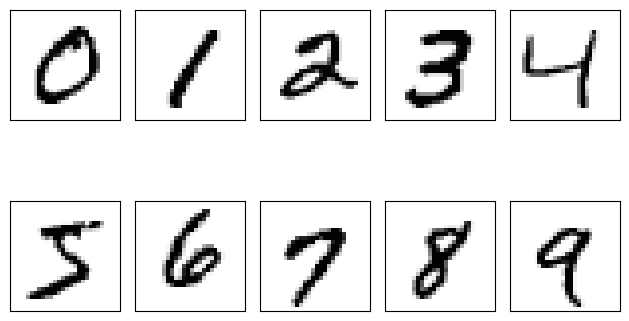

In [33]:
# reshape 784-pixel vectors into original 28x28 pixels
# plot images
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2,
                       ncols=5,
                       sharex=True,
                       sharey=True)

ax = ax.flatten()

for i in range(10):
  img = X[y == i][0].reshape(28, 28)
  ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

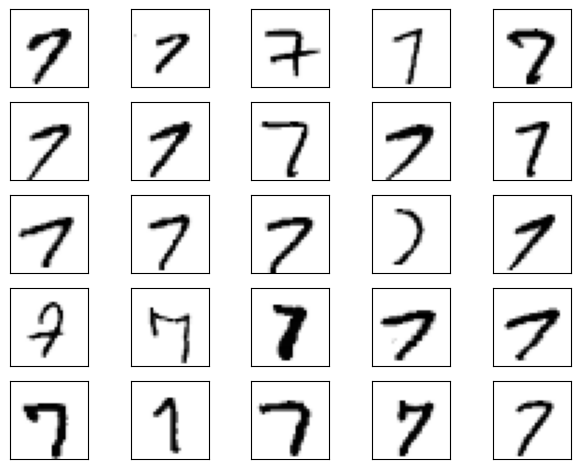

In [35]:
# plot multiple examples of samme digit to compare difference
fig, ax = plt.subplots(nrows=5,
                       ncols=5,
                       sharex=True,
                       sharey=True)

ax = ax.flatten()

for i in range(25):
  img = X[y == 7][i].reshape(28, 28)
  ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [36]:
# split training set into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=5000,
                                                  stratify=y)

X_train.shape, X_val.shape

((55000, 784), (5000, 784))

## Implementing a multilayer perceptron

In [37]:
import numpy as np

In [38]:
########################
#### MODEL
########################

def sigmoid(z):
  return 1. / (1 + np.exp(-z))

def int_to_onehot(y, num_labels):
  arr = np.zeros((y.shape[0], num_labels))

  for i, val in enumerate(y):
    arr[i, val] = 1 # assign 1 to row ith and col val-th

  return arr

In [41]:
y_train[:10], int_to_onehot(y_train[:10], 10)

(array([6, 6, 6, 5, 2, 1, 2, 9, 9, 5]),
 array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]]))

In [42]:
# define model and use MSE loss
class NeuralNetMLP:
  def __init__(self,
              num_features,
              num_hidden,
              num_classes,
              random_seed=123):
    super().__init__()

    self.num_classes = num_classes

    # hidden layers
    rng = np.random.RandomState(random_seed)

    self.weight_h = rng.normal(loc=0.0,
                               scale=0.1,
                               size=(num_hidden, num_features))
    self.bias_h = np.zeros(num_hidden)

    # output layer
    self.weight_out = rng.normal(loc=0.0,
                                 scale=0.1,
                                 size=(num_classes, num_hidden))
    self.bias_out = np.zeros(num_classes)

  def forward(self, x):
    # Hidden layer
    # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
    # output dim: [n_examples, n_hidden]
    z_h = np.dot(x, self.weight_h.T) + self.bias_h
    a_h = sigmoid(z_h)

    # Output layer
    # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
    # output dim: [n_examples, n_classes]
    z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
    a_out = sigmoid(z_out)

    return a_h, a_out

  def backward(self, x, y, a_h, a_out):

    ########################
    ### Output layer weights
    ########################

    # onehot encodin
    y_onehot = int_to_onehot(y, self.num_classes)

    # Part 1: dLoss/dOutWeights
    # = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeights
    # set DeltaOut = dLoss/dOutAct * dOutAct/dOutNet for reuse

    # input/output dim: [n_examples, n_classes]
    # calculate partial deriavtive of loss w.r.t sigmoid activation
    d_loss__d_a_out = 2. * (a_out - y_onehot) / y.shape[0]

    # input/output dim: [n_examples, n_classes]
    # sigmoid derivative
    d_a_out__d_z_out = a_out * (1 - a_out)

    # output dim: [n_examples, n_classes]
    # represents how much error flows back from output layers to input
    delta_out = d_loss__d_a_out * d_a_out__d_z_out

    ### Gradient for output weights

    # [n_examples, n_hidden]
    d_z_out__d_w_out = a_h

    # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
    # output dim: [n_classes, n_hidden]
    d_loss__d_w_out = np.dot(delta_out.T, d_z_out__d_w_out)
    d_loss__d_b_out = np.sum(delta_out, axis=0)

    #################################################
    # Part 2: dLoss/dWeights
    # = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet *
    # dHiddenNet/dWeights
    ############################################################

    # [n_classes, n_hidden]
    d_z_out__a_h = self.weight_out

    # output dim: [n_examples, n_hidden]
    d_loss__a_h = np.dot(delta_out, d_z_out__a_h)

    # [n_examples, n_features]
    d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative

    d_z_h__d_w_h = x

    # output dim: [n_hidden, n_features]
    d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
    d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

    return (d_loss__d_w_out, d_loss__d_b_out,
            d_loss__d_w_h, d_loss__d_b_h)

In [43]:
model = NeuralNetMLP(num_features=28*28,
                     num_hidden=50,
                     num_classes=10)
model

## Training loop

In [44]:
epochs = 50
batch_size = 100

def batch_generator(X, y, batch_size):
  indices = np.arange(X.shape[0])
  np.random.shuffle(indices)

  for start_idx in range(0,
                         indices.shape[0] - batch_size + 1,
                         batch_size):
    batch_idx = indices[start_idx : start_idx+batch_size]

    yield X[batch_idx], y[batch_idx]


In [45]:
# test function
for i in range(epochs):
  batch_gen = batch_generator(X_train,
                              y_train,
                              batch_size)

  for X_train_batch, y_train_batch in batch_gen:
    break
  break

print(X_train_batch.shape, y_train_batch.shape)

(100, 784) (100,)


In [46]:
# implement MSE loss function
def mse_loss(y_true, probs, num_labels=10):
  onehot_targets = int_to_onehot(y_true, num_labels)
  return np.mean((onehot_targets - probs) ** 2)

# acc function
def accuracy(y_true, y_pred):
  return np.mean(y_true == y_pred)


In [47]:
# test preceding functions and compute initial validation
# set MSE and accuracy of model
_, probs = model.forward(X_val)

mse = mse_loss(y_val, probs)
print(f'Initial validation MSE: {mse:.3f}')

Initial validation MSE: 0.271


In [53]:
probs.shape, probs[:2]

((5000, 10),
 array([[0.57523559, 0.56687544, 0.57240161, 0.41409665, 0.48158265,
         0.50438989, 0.38349638, 0.38530427, 0.66054058, 0.56438348],
        [0.57476058, 0.5859001 , 0.56458588, 0.39922452, 0.5508306 ,
         0.51177598, 0.37786509, 0.38089321, 0.70345539, 0.61944144]]))

In [51]:
y_pred = np.argmax(probs, axis=1)
y_pred.shape

(5000,)

In [54]:
acc = accuracy(y_val, y_pred)
acc

np.float64(0.0974)

In [57]:
#  compute MSE and accuracy incrementally bu iterating
# over datasset one batch at a time for memory efficiency
def compute_mse_and_acc(nnet, X, y,
                        num_labels=10,
                        batch_size=100):
  mse, correct_pred, num_examples = 0, 0, 0
  batch_gen = batch_generator(X, y, batch_size)

  for i, (features, targets) in enumerate(batch_gen):
    _, probs = nnet.forward(features)
    y_pred = np.argmax(probs, axis=1)
    onehot_targets = int_to_onehot(targets, num_labels)
    loss = mse_loss(targets, probs)
    correct_pred += (y_pred == targets).sum()
    num_examples += targets.shape[0]
    mse += loss

  mse /= i
  acc = correct_pred / num_examples

  return mse, acc


In [58]:
mse, acc = compute_mse_and_acc(model, X_val, y_val)
mse, acc

(np.float64(0.2766687184701708), np.float64(0.0974))

In [61]:
# implement train function
def train(model,
          X_train, y_train,
          X_val, y_val,
          epochs,
          lr):
  epoch_loss = []
  epoch_val_loss = []
  epoch_train_acc = []
  epoch_val_acc = []

  for epoch in range(epochs):
    # iterate over batches
    batch_gen = batch_generator(X_train,
                                y_train,
                                batch_size)

    for X_train_batch, y_train_batch in batch_gen:
      # compute outputs
      a_h, a_out = model.forward(X_train_batch)

      # Compute gradeints
      d_loss__d_w_out, d_loss__d_b_out, \
      d_loss__d_w_h, d_loss__d_b_h = model.backward(X_train_batch,
                                                    y_train_batch,
                                                    a_h, a_out)

      # Update weights
      model.weight_out -= lr * d_loss__d_w_out
      model.bias_out -= lr * d_loss__d_b_out
      model.weight_h -= lr * d_loss__d_w_h
      model.bias_h -= lr * d_loss__d_b_h

    ### Epoch Logging ###
    train_mse, train_acc = compute_mse_and_acc(model,
                                               X_train,
                                               y_train)
    val_mse, val_acc = compute_mse_and_acc(model,
                                           X_val,
                                           y_val)

    epoch_train_acc.append(train_acc)
    epoch_val_acc.append(val_acc)
    epoch_loss.append(train_mse)
    epoch_val_loss.append(val_mse)

    print(f'Epoch: {epoch+1:03d}/{epochs:03d} '
          f' | Train MSE: {train_mse:.3f} '
          f' | Valid MSE: {val_mse:.3f} '
          f' | Train Acc: {train_acc:.2f} '
          f' | Valid Acc: {val_acc:.2f}')

  return epoch_loss, epoch_val_loss, epoch_train_acc, epoch_val_acc

In [62]:
epoch_loss, epoch_val_loss, epoch_train_acc, epoch_val_acc = \
  train(model=model,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        epochs=epochs,
        lr=0.01)

Epoch: 001/050  | Train MSE: 0.086  | Valid MSE: 0.087  | Train Acc: 0.34  | Valid Acc: 0.35
Epoch: 002/050  | Train MSE: 0.082  | Valid MSE: 0.084  | Train Acc: 0.44  | Valid Acc: 0.45
Epoch: 003/050  | Train MSE: 0.078  | Valid MSE: 0.079  | Train Acc: 0.53  | Valid Acc: 0.54
Epoch: 004/050  | Train MSE: 0.073  | Valid MSE: 0.074  | Train Acc: 0.60  | Valid Acc: 0.61
Epoch: 005/050  | Train MSE: 0.068  | Valid MSE: 0.069  | Train Acc: 0.66  | Valid Acc: 0.66
Epoch: 006/050  | Train MSE: 0.063  | Valid MSE: 0.064  | Train Acc: 0.70  | Valid Acc: 0.70
Epoch: 007/050  | Train MSE: 0.058  | Valid MSE: 0.059  | Train Acc: 0.73  | Valid Acc: 0.72
Epoch: 008/050  | Train MSE: 0.054  | Valid MSE: 0.055  | Train Acc: 0.75  | Valid Acc: 0.75
Epoch: 009/050  | Train MSE: 0.050  | Valid MSE: 0.051  | Train Acc: 0.77  | Valid Acc: 0.76
Epoch: 010/050  | Train MSE: 0.047  | Valid MSE: 0.048  | Train Acc: 0.78  | Valid Acc: 0.77
Epoch: 011/050  | Train MSE: 0.044  | Valid MSE: 0.045  | Train Acc: 0

## Evaluating performance

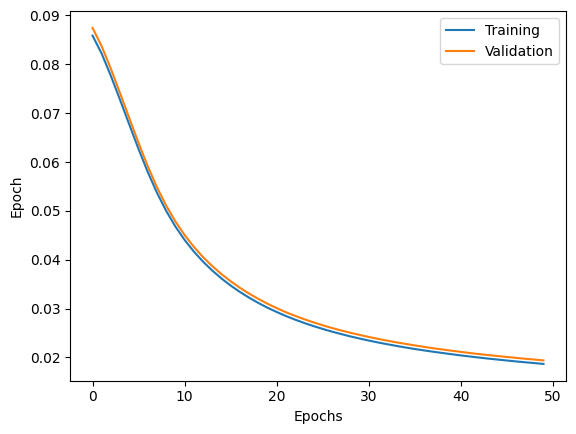

In [65]:
# plot training and validation loss
plt.plot(range(len(epoch_loss)),
         epoch_loss,
         label='Training')
plt.plot(range(len(epoch_val_loss)),
         epoch_val_loss,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Epoch')
plt.legend()
plt.show()

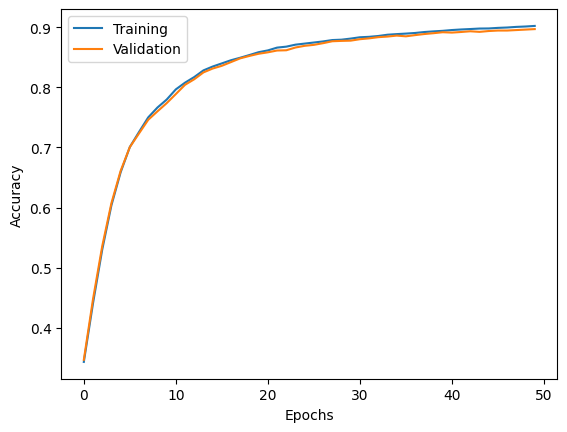

In [66]:
# plot training and validation accuracy
plt.plot(range(len(epoch_train_acc)),
         epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_val_acc)),
         epoch_val_acc,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [67]:
# Evaluate generalization performance of model
test_mse, test_acc = compute_mse_and_acc(model,
                                         X_test,
                                         y_test)

print(f'Test MSE: {test_mse:.3f}'
      f' | Test acc: {test_acc:.2f}')

Test MSE: 0.018 | Test acc: 0.91


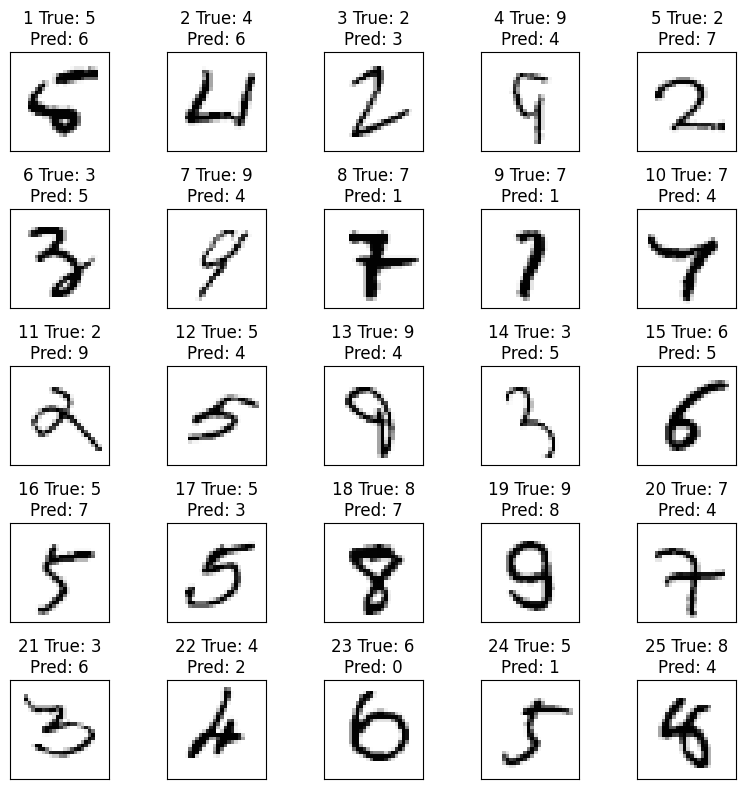

In [71]:
# extract and plot first 25 misclassified samples from test set
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_, probs = model.forward(X_test_subset)
test_pred = np.argmax(probs, axis=1)

misclassified_img = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

fig, ax = plt.subplots(nrows=5,
                       ncols=5,
                       sharex=True,
                       sharey=True,
                       figsize=(8, 8))
ax = ax.flatten()

for i in range(25):
  img = misclassified_img[i].reshape(28, 28)
  ax[i].imshow(img, cmap='Greys', interpolation='nearest')
  ax[i].set_title(f'{i+1} '
                  f'True: {correct_labels[i]}\n'
                  f'Pred: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()
